In [1]:
"""
Two fluid model
compressible
differential equation system
well-posedness analysis
"""

# Libraries
from IPython.display import clear_output
from math import pi
from matplotlib import (rc, style)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.optimize import (brenth, fsolve)
from scipy.linalg import eigvals, eig
from scipy.sparse.linalg import eigs
from scipy.interpolate import interp1d

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import time

# General configuration for plots
%matplotlib inline
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 18
        }
matplotlib.rc('font',family = 'Times New Roman')

# Phase properties
c2               = 293.43 # Sanderse 2017
u4eq             = 1e5 # Pa, outlet pressure (equilibrium state)
rho1             = 1000 # kg m^-3, liquid density (Montini)
mu1              = 8.9e-4 # Pa s, liquid viscosity
mu2              = 1.8e-5 # Pa s, gas viscosity

# Gravity
g                = 9.8 # m/s^2

# Configuration
d                = 0.078 # 0.022 # m, diameter
L                = 1 # m, pipe length
beta1            = - 5 # (Taitel 1976)
beta2            = 0.25 # - 0.5(Taitel 1976)
beta3            = 0
A                = pi*pow (d, 2.)/4. # mˆ2, total area
S                = pi*d
roughness        = 1e-8 # m, pipe roughness

# Well-posedness map
minj1            = 1e-2 # epstest
maxj1            = 5
testpointsj1     = 1000 # 250 for well-posedness

minj2            = 1e-1 # epstest
maxj2            = 30
testpointsj2     = testpointsj1 # 150

betavectordeg    = np.array ([beta1, beta3, beta2] ) # deg 
testpointsbeta   = len (betavectordeg)
betavector       = np.deg2rad (betavectordeg) #betavectordeg*pi/180 # radnL:>W###

# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

# Scatter for well-posedness analysis
j1scatter1       = 2
j2scatter1       = 2
j1mapscatter1    = np.zeros ((testpointsbeta, j1scatter1)) #(rows,columns)
j2mapscatter1    = np.zeros ((testpointsbeta, j2scatter1)) #(rows,columns) 
j2test1          = np.array([[0, 0], 
                             [6., 6.532], 
                             [0, 0]])
j1test1          = np.array([[0, 0], 
                             [0.4, 0.532], 
                             [0, 0]])

# Scatter for Bi-Global stability, local stability and regularized tfm equations
j1scatter2       = 3
j2scatter2       = 3
j1mapscatter2    = np.zeros ((testpointsbeta, j1scatter2)) #(rows,columns)
j2mapscatter2    = np.zeros ((testpointsbeta, j2scatter2)) #(rows,columns) 
j2test2          = np.array([[0.4 , 0.4, 0.4], 
                             [0.4 , 0.4, 0.4], 
                             [5.0 , 5.0, 5.0]])
j1test2          = np.array([[0.3, 0.7, 2.0], 
                             [0.08, 0.5, 2.0], 
                             [0.05, 0.5, 2.0]])

# Stability
lambda_test      = d                        
eignumber        = 4
epstest          = 2.2250738585072014e-10
minlambda        = epstest
maxlambda        = L
testpointslambda = 1000 # 250
steplambda       = (maxlambda - epstest)/30 # for ticks in local stability analysis
limitlog         = 0.001
    
# Numerical difussion for Fourier analysis
Gammavector      = np.array ([[0 , 0   , 0   ], 
                              [0 , 0   , 5e-1], 
                              [0 , 1e-1, 4e-1]])
Art_mu1vector    = np.array ([[0 , 0   , 0   ], 
                              [0 , 0   , 2e-1], #when Art_mu decreases 1e-1 to 1e-5 the maximum G reduces to less than 1e3 
                              [0 , 2e-1, 2e-1]])
Art_mu2vector    = np.array ([[0 , 0   , 0   ], 
                              [0 , 0   , 2e-1], #when Art_mu decreases 1e-1 to 1e-5 the maximum G reduces to less than 1e3 
                              [0 , 2e-1, 2e-1]])

In [2]:
# FUNCTIONS
# stratification angle
def gamma (u1):
    return 2*(pi*(1. - u1) + pow (abs(3.*pi/2.), (1./3.))*(2.*u1 - 1. + pow (abs (1. - u1), (1./3.))- pow (abs(u1), (1/3))) - (1./200.)*u1*(1. - u1)*(2.*u1 - 1.)*(1. + 4.*(pow (abs (u1), 2.) + pow (abs(1.- u1), 2.))))
# liquid holdup
def alpha1 (u1):
    return 1 - u1

# liquid phase velocity
def u3 (u1):
    return j1/(1. - u1)
# liquid phase velocity
def u3b (j1):
    return j1/(1. - u1)
# gas phase velocity
def u2 (u1):
    return j2/u1

# liquid sectional area
def A1 (gamma):
    return (d**2)/4*(gamma/2 - np.sin (gamma/2)*np.cos (gamma/2))
# gas sectional area
def A2 (gamma):
    return (d**2)/4*(pi - gamma/2 + np.sin (gamma/2)*np.cos (gamma/2))
# liquid wetted perimeter
def S1 (gamma):
    return d*gamma/2.
# gas wetted perimeter
def S2 (gamma):
    return d/2.*(2.*pi - gamma)
# interface wetted perimeter
def Si (gamma):
    return d*np.sin (gamma/2)

# liquid hydraulic diameter 
def dh1 (A1, S1):
    return 4.*A1/S1
# gas hydraulic diameter 
def dh2 (A2, S2, Si):
    return 4.*A2/(S2 + Si)
# critic diameter
def Dc (gamma):
    return g*np.cos (beta)*pi*d/(4*np.sin (gamma/2))

# liquid Reynolds number
def Re1 (u3, dh1):
    return rho1*u3*dh1/mu1
# gas Reynolds number
def Re2 (u2, dh2):
    return u4eq/pow ((c2), 2)*u2*dh2/mu2

# liquid shear stress
def tauw1 (f1, u3):
    return f1*rho1*u3*abs (u3)/2.
# gas shear stress
def tauw2 (f2, u2):
    return f2*u4eq/pow (c2, 2)*u2*abs (u2)/2.
# interface shear stress
def tau21 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u2 - u3)*abs (u2 - u3)/2.
# interface shear stress
def tau12 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u3 - u2)*abs (u3 - u2)/2.

# liquid friction factor 1
def f1 (Re1, dh1):
    Af1 = pow (2.457*np.log(pow(pow(abs(7/Re1), 0.9) + 0.27*roughness/dh1, - 1)), 16)
    Bf1 = pow (abs (37530/Re1), 16)
    return 2*pow (pow (abs (8/Re1), 12)+pow (abs (Af1 + Bf1), - 1.5), 1/12)

# gas friction factor 2
def f2 (Re2, dh2):
    Af2 = pow (2.457*np.log(pow(pow(abs(7/Re2), 0.9) + 0.27*roughness/dh2, - 1)), 16)
    Bf2 = pow (abs (37530/Re2), 16)
    return 2*pow (pow (abs (8/Re2), 12)+pow (abs (Af2 + Bf2), - 1.5), 1/12)

# interfacial friction
def fi (f2):
    return max (f2, 0.014)

# steady state momentum equation
def equilibrium1 (u1): 
    func = - (rho1 - u4eq/pow (c2, 2))*g*np.sin (beta) - tauw1 (f1 (Re1 (u3 (u1), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), u3 (u1))*S1 (gamma (u1))/A1 (gamma(u1)) + tauw2 (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), u2 (u1))*S2 (gamma (u1))/A2(gamma (u1)) + tau21 (fi (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si(gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1))))), u3 (u1), u2 (u1))*Si(gamma (u1))*((1/A1 (gamma (u1))) + (1/A2 (gamma (u1))))
    return func

# Local equailibrium theory
def equilibrium2 (j1):  
    func = - (rho1 - u4eq/pow (c2, 2))*g*np.sin (beta) - tauw1 (f1 (Re1 (u3b (j1), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), u3b (j1))*S1 (gamma (u1))/A1 (gamma(u1)) + tauw2 (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), u2 (u1))*S2 (gamma (u1))/A2(gamma (u1)) + tau21 (fi (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si(gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1))))), u3b (j1), u2 (u1))*Si(gamma (u1))*((1/A1 (gamma (u1))) + (1/A2 (gamma (u1))))
    return func

# Jacobian matricesS
def Amat (u4, u3, u2, u1):  
    Amat = [[u4/pow (c2, 2)   , 0                , 0            , u1/pow (c2,2)   ], 
            [ - rho1          , 0                , 0            , 0               ],
            [u2*u4/pow (c2, 2), u1*u4/pow (c2, 2), 0            , u1*u2/pow (c2,2)],
            [ - u3*rho1       , 0                , (1 - u1)*rho1, 0               ]]
    return Amat

def Bmat(u4, u3, u2, u1, Dc):  
    Bmat = [[u2*u4/pow (c2, 2)                                      , u1*u4/pow (c2, 2)     , 0                 , u1*u2/pow (c2,2)             ], 
            [ - u3*rho1                                             , 0                     , (1 - u1)*rho1     , 0                            ],
            [pow (abs (u2), 2)*u4/pow (c2, 2) - u4/pow (c2, 2)*u1*Dc, 2*u1*u2*u4/pow (c2, 2), 0                 , u1 + u1*pow (u2,2)/pow (c2,2)],
            [ - pow (abs (u3), 2)*rho1 - rho1*(1 - u1)*Dc           , 0                     , 2*(1 - u1)*rho1*u3, (1 - u1)                     ]]
    return Bmat

def Dmat (u4, u3, u2, u1, S1, S2, Si, f1, f2, fi):  #COMB 2
    Dmat = [[0                               , 0                                                                                                       , 0                                                                                                      , 0                                                                                                                     ], 
            [0                               , 0                                                                                                       , 0                                                                                                      , 0                                                                                                                     ],
            [(u4/pow (c2, 2)*g*np.sin (beta)), 1/2*fi*u4/pow (c2, 2)*Si/A*((u2 - u3) + abs(u2 - u3)) + 1/2*f2*u4/pow (c2, 2)*S2/A*(abs (u2) + abs (u2)), 1/2*fi*u4/pow (c2, 2)*Si/A*( - abs (u2 - u3) - abs (u2 - u3))                                          , u1*g*np.sin (beta)/pow (c2, 2) + 1/2*fi/pow (c2, 2)*Si/A*(u2 - u3)*abs (u2 - u3) + 1/2*f2/pow (c2, 2)*S2/A*u2*abs (u2)],
            [( - rho1*g*np.sin (beta))       , 1/2*fi*u4/pow (c2, 2)*Si/A*((-abs (u3 - u2) - abs(u3 - u2)))                                            , 1/2*fi*u4/pow (c2, 2)*Si/A*((abs (u2 - u3) + abs (u3 - u2))) + 1/2*f1*rho1*S1/A*((abs (u3) + abs (u3))), 1/2*fi*1/pow (c2,2)*Si/A*(((u3 - u2)*abs (u3 - u2)))                                                                  ]] 
    return Dmat

def Emat (u4, u1, Gamma1, Art_mu1, Art_mu2):  #Art_mu1 = Art_mu2
    Emat = [[ - u4/pow (c2, 2)*Gamma1, 0           , 0                 , 0], 
            [rho1*Gamma1             , 0           , 0                 , 0],
            [0                       , - Art_mu2*u1, 0                 , 0],
            [0                       , 0           , - Art_mu1*(1 - u1), 0]]
    return Emat 

In [3]:
"""
WELL-POSEDESS MAP
"""
# superficial velocities
j1vector           = np.linspace (minj1, maxj1, num = testpointsj1)
j2vector           = np.linspace (minj2, maxj2, num = testpointsj2) #*****MODIFIQUE DE 1.000, 10.000 PARA 1,1

#MAP MATRICES----------------------------------------------------------------------------------------------------
j1mapwellposedness = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)
u1map              = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)

k = 0
for beta in betavector:
    print (" >>> β =", np.rad2deg (beta), "[°]")
    j = 0 #for each element of j2vector
    for j2 in j2vector: #iterative process for j2
        #print (">>j2 = ", j2)
        i = 0 #for each element of j1vector
        for j1 in j1vector: #iterative process for j1
            #print (">j1 = ", j1)
            
            #print ("Local equilibrium theory")
            # finding the solution with fsolve
            
            #https://docs.scipy.org/doc/scipy/reference/optimize.html
            lima    = 1e-15
            limb    = 1 - lima
            u1eq    = brenth (equilibrium1, lima, limb)
            
            # A variation on the classic Brent routine to find a zero of the function f between the arguments 
            # a and b that uses hyperbolic extrapolation instead of inverse quadratic extrapolation. There 
            # was a paper back in the 1980’s ... f(a) and f(b) can not have the same signs. Generally on a par 
            #with the brent routine, but not as heavily tested. It is a safe version of the secant method that 
            #uses hyperbolic extrapolation. The version here is by Chuck Harris.
            
            #x0         = 0.001  #initial guess
            #alpha2eq   = fsolve (equilibrium, x0) #Python function
            
            #print("alpha2eq = ", alpha2eq)

            # parameters used in boundary conditions
            u1_0     = u1eq
            u2_0     = u2 (u1eq)
            u3_0     = u3 (u1eq)
            u4_0     = u4eq
            
            Aeval    = np.asarray (Amat (u4_0, u3_0, u2_0, u1_0))
            Aeval    = Aeval.astype (float)
            #print("Aeval = ", Aeval)

            #print(type(ge(gamma)[0]))
            #print(type(rho1))
            Beval    = np.asarray (Bmat (u4_0, u3_0, u2_0, u1_0, Dc (gamma (u1_0))))
            Beval    = Beval.astype (float)
            #print("Beval = ", Beval)
            
            #criterion for the well-posedness
            #https://scipy.github.io/devdocs/tutorial/arpack.html
            
            m        = eigvals (Aeval, b = Beval, overwrite_a = True)
            #m = eigs (Beval, k = eignumber, M = Aeval, sigma = None, which = 'LI', v0 = 0, ncv = 2*eignumber + 1, maxiter = None, tol = 0, return_eigenvectors = False, Minv = None, OPinv = None, OPpart = None)
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html#scipy.sparse.linalg.eigs
            
            #print("eigenvalues = ", m)
            length1  = len (m)
            
            #print("eigenvaluesvector = ", eigenvaluesvector)
            listreal = []
            listimag = []
            
            l        = 0
            for l in range (length1):
                #print("l =", l)
                realpart = m [l].real                
                imagpart = m [l].imag
                
                listimag.append (imagpart)
                listreal.append (realpart)
            
            #print("listreal =", listreal)
            #print("listimag =", listimag)
            if all ([ v == 0 for v in listimag ]) :
                i += 1
            else: 
                j1mapwellposedness [k, j] = j1
                u1map [k, j]              = u1eq
                #print("\n== ill-posed\n")
                #print("j2       =", j2)
                #print("j1       =", j1)   
                break
        j += 1
    k += 1

 >>> β = -5.0 [°]
 >>> β = 0.0 [°]
 >>> β = 0.25 [°]


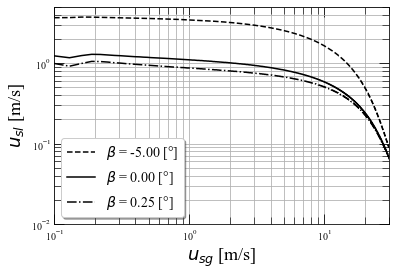

In [4]:
"""
WELL-POSEDNESS MAP: PLOT
"""
x          = j2vector
fig, ax    = plt.subplots (1)

for i in range(testpointsbeta):
    ax.loglog (x, 
               j1mapwellposedness [i, :], 
               liststyles [i], color = listcolor [0],
               label =  r'$\beta$' + ' = ' + str ("%.2f" %betavectordeg [i]) + ' [°]')

    #ax.scatter (mapreal [number], mapimag [number], s = area, marker = listmarkers[number], color='k', alpha = 0.5, label = '$j_1$' + '=' +str("%.2f" %j1vector [number]) + ' m/s')

    # Savitzky-Golay Filter
    #for numero in arange: #scipy.signal.savgol_filter: window size 51, polynomial order 3
    #    ax.loglog (x, scipy.signal.savgol_filter(j1map [numero,:], 91, 3), label = '$beta$' + '='+str("%.2f" %betavectordeg [numero]) + ' deg')

    #plt.title('Well-posedness limit for horizontal and inclined pipes')

#     style.use('ggplot')
    
    plt.ylim ((minj1, maxj1))
    plt.xlim ((minj2, maxj2))

    #tick_params(labeltop=False, labelright=True)
    plt.grid (True, which = "both")

    plt.rcParams ['figure.figsize'] = [12, 8]
    leg = ax.legend (loc = 'best', fontsize = 14, shadow = True, frameon = True,);

    matplotlib.rc ('xtick', labelsize = 18)     
    matplotlib.rc ('ytick', labelsize = 18)
    
    ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

    ax.set_xlabel(r'$u_{sg}$ [m/s]',
                  fontsize = 18)
    ax.set_ylabel(r'$u_{sl}$ [m/s]',
                  fontsize = 18)

    plt.savefig('09_comp_TFM_stability/well-posedness_map_1.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

plt.show ()


In [5]:
"""
CONSTANT VOID FRACTION LINES (alpha = 0.5) for downflow and horizontal
"""
j2vectorline = np.linspace (minj2, maxj2, num = testpointsj2) #*****MODIFIQUE DE 1.000, 10.000 PARA 1,1
u1           = 0.5
j1linemap    = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)

k            = 0
for beta in betavector:
    print (" >>> β = ", np.rad2deg(beta), "[°]")
    j = 0 #for each element of j2vector
    for j2 in j2vectorline: #iterative process for j2        
        x0               = 0.001  #initial guess
        j1line           = fsolve (equilibrium2, x0) #Python function        
        j1linemap [k, j] = j1line
        j += 1
    k += 1

 >>> β =  -5.0 [°]
 >>> β =  0.0 [°]
 >>> β =  0.25 [°]


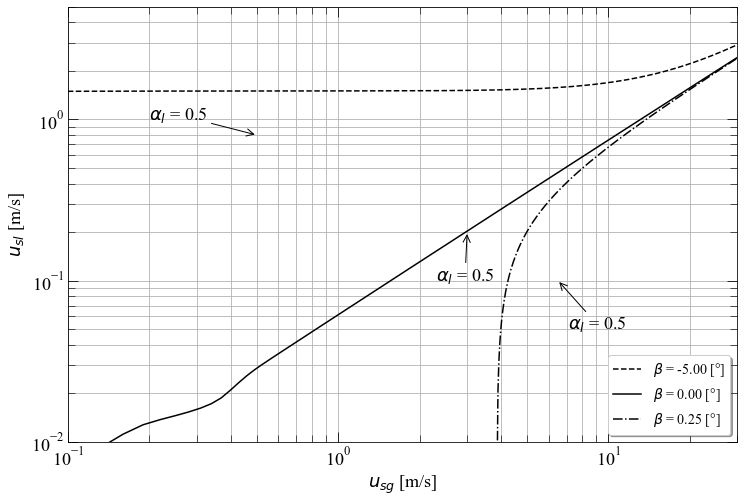

<Figure size 864x576 with 0 Axes>

In [6]:
"""
CONSTANT VOID FRACTION LINES (alphal = 0.5)
"""
x       = j2vectorline
fig, ax = plt.subplots (1)

for i in range(testpointsbeta):
    ax.loglog (x,
               j1linemap [i, :],
               liststyles [i],
               color = listcolor [0],
               label =  r'$\beta$' + ' = ' + str("%.2f" %betavectordeg [i]) + ' [°]')

    #ax.scatter (mapreal [number], mapimag [number], s = area, marker = listmarkers[number], color='k', alpha = 0.5, label = '$j_1$' + '=' +str("%.2f" %j1vector [number]) + ' m/s')
        
# Savitzky-Golay Filter
#for numero in arange: #scipy.signal.savgol_filter: window size 51, polynomial order 3
#    ax.loglog (x, scipy.signal.savgol_filter(j1map [numero,:], 91, 3), label = '$beta$' + '='+str("%.2f" %betavectordeg [numero]) + ' deg')

#plt.title('Well-posedness limit for horizontal and inclined pipes')

plt.ylim ((minj1, maxj1))
plt.xlim ((minj2, maxj2))

#tick_params(labeltop=False, labelright=True)
plt.grid (True, which = "both")

plt.rcParams ['figure.figsize'] = [12, 8]
leg = ax.legend (loc = 'best', fontsize = 14, shadow = True, frameon = True);

matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

# Annotation for alpha_l
ax.annotate(r'$\alpha_l$ = 0.5', 
            xy=(0.5, 0.8), xycoords='data', size=18,
            xytext=(0.2, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.annotate(r'$\alpha_l$ = 0.5', 
            xy=(3, 0.2), xycoords='data', size=18,
            xytext=(2.3, 0.1), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.annotate(r'$\alpha_l$ = 0.5', 
            xy=(6.5, 0.1), xycoords='data', size=18,
            xytext=(7.1, 0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
# plt.text(0.3, 0.6, r'$\alpha_l$ = 0.5', fontsize = 18)
# plt.text(2.3, 0.1, r'$\alpha_l$ = 0.5', fontsize = 18)
# plt.text(7.1, 0.05, r'$\alpha_l$ = 0.5', fontsize = 18)

ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

ax.set_xlabel(r'$u_{sg}$ [m/s]',
            fontsize = 18)
ax.set_ylabel(r'$u_{sl}$ [m/s]',
            fontsize = 18)

plt.show ()

plt.savefig('09_comp_TFM_stability/well-posedness_map_2.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

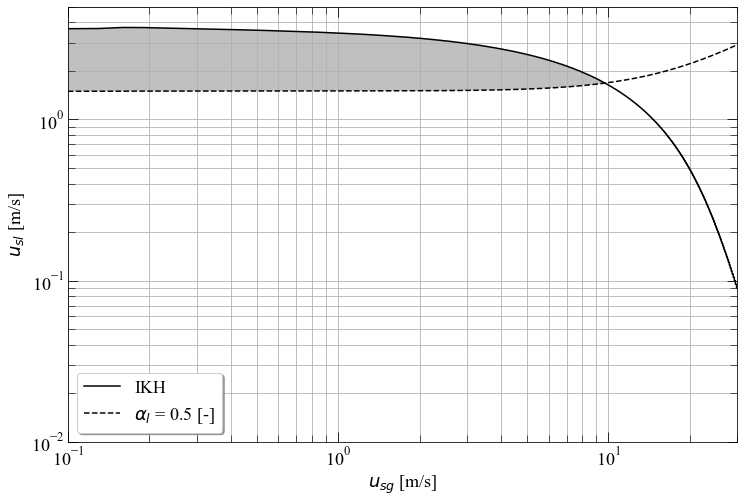

<Figure size 864x576 with 0 Axes>

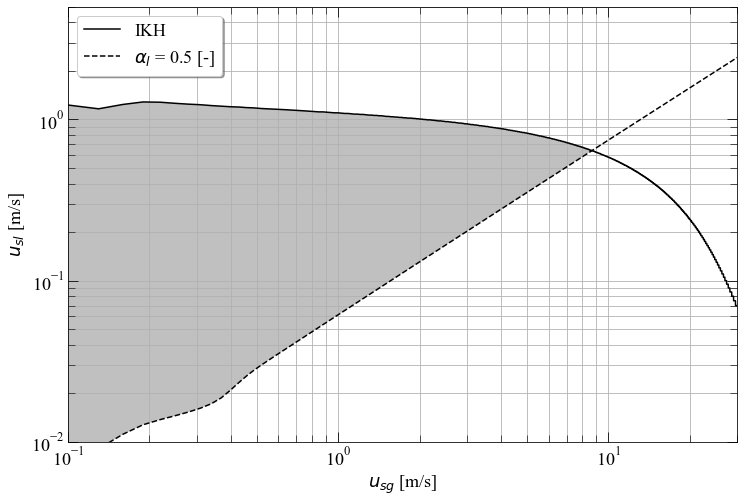

<Figure size 864x576 with 0 Axes>

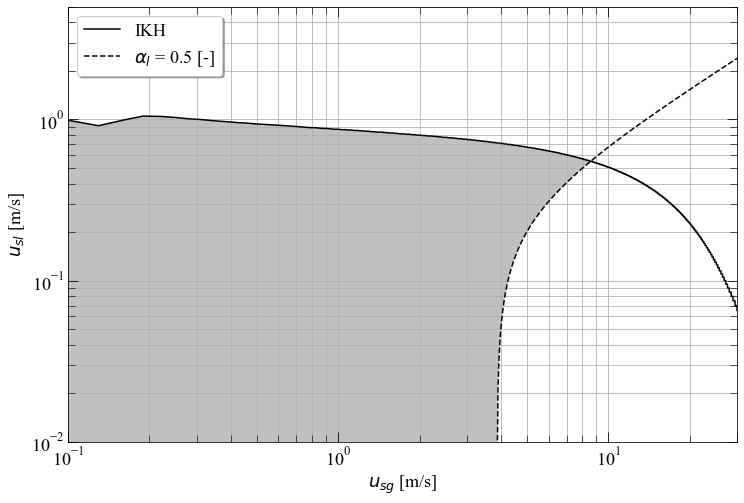

<Figure size 864x576 with 0 Axes>

In [7]:
"""
WELL-POSEDNESS MAP: PLOT with constant alpha lines
"""
x = j2vector

for i in range(testpointsbeta):
#     print("i = ", i)
    fig, ax   = plt.subplots () ###try (3)
    ax.loglog (x, j1mapwellposedness [i, :],
               liststyles [1], color = listcolor [0],
               label =  'IKH')
    ax.loglog (x,
               j1linemap [i, :],
               liststyles [0], color = listcolor [0],
               label =  '$α_l$ = 0.5 [-]')
    
    # Fill
    ax.fill_between(x,
                    j1linemap [i, :],
                    j1mapwellposedness [i, :],
                    where = j1mapwellposedness [i, :] >= j1linemap [i, :],
                    facecolor = 'silver',
                    interpolate = True)    #ax.scatter (mapreal [number], mapimag [number], s = area, marker = listmarkers[number], color='k', alpha = 0.5, label = '$j_1$' + '=' +str("%.2f" %j1vector [number]) + ' m/s')
    
    #Scatter for test points
#     ax.plot(j1test1 [i, :], listmarkers[1], j2test1 [i, :], listmarkers[3], color = 'black', fillstyle = 'none', markersize = 10, markeredgewidth = 1)
#     area = 100
#     ax.scatter (j2test1 [i, :], j1test1 [i, :], s = area, color = listcolor [4], marker = listmarkers[i], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
#     ax.set_xscale ('symlog')
    
    plt.ylim ((minj1, maxj1))
    plt.xlim ((minj2, maxj2))

    #tick_params(labeltop=False, labelright=True)
    plt.grid (True, which = "both")
    plt.rcParams ['figure.figsize'] = [12, 8]
    leg = ax.legend (loc = 'best', fontsize = 18, shadow = True);

    matplotlib.rc ('xtick', labelsize = 18)     
    matplotlib.rc ('ytick', labelsize = 18)
    
    ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
    
    ax.set_xlabel(r'$u_{sg}$ [m/s]',
            fontsize = 18)
    ax.set_ylabel(r'$u_{sl}$ [m/s]',
            fontsize = 18)
    
    plt.show ()

    plt.savefig('09_comp_TFM_stability/well-posedness_map_3_'+ str(i) +'.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

    i += 1

 >>>  =  -1.5000000000000002 [deg]
>>j2 =  6.0
>j1 =  0.01
eigenvalues =  [ 299.56501938+0.j -287.30245401+0.j    0.30113856+0.j    0.63220492+0.j]
>j1 =  2.0
eigenvalues =  [ 315.91912004+0.j         -271.86582372+0.j
    2.80649558+0.83349098j    2.80649558-0.83349098j]


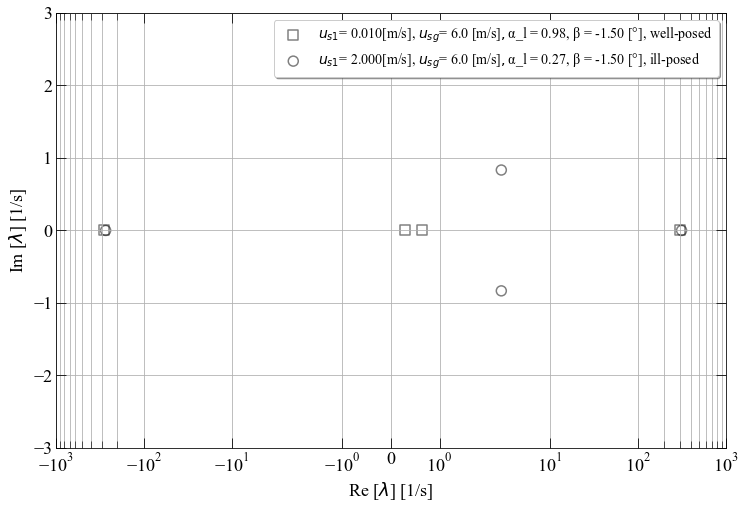

 >>>  =  0.0 [deg]
>>j2 =  6.0
>j1 =  0.01
eigenvalues =  [ 2.99682757e+02+0.j -2.87191236e+02+0.j  5.12747339e-02+0.j
  4.57010240e-01+0.j]
>j1 =  2.0
eigenvalues =  [ 319.9140945 +0.j         -268.10233057+0.j
    2.6914425 +1.26683414j    2.6914425 -1.26683414j]


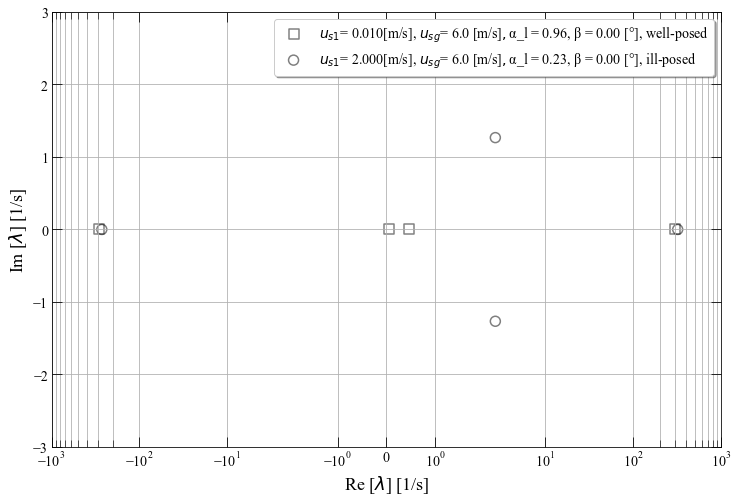

 >>>  =  0.5 [deg]
>>j2 =  6.0
>j1 =  0.01
eigenvalues =  [ 304.68484386+0.j -282.46714   +0.j   -0.36013347+0.j    0.42561057+0.j]
>j1 =  2.0
eigenvalues =  [ 321.17063397+0.j        -266.91946048+0.j
    2.66763825+1.4046349j    2.66763825-1.4046349j]


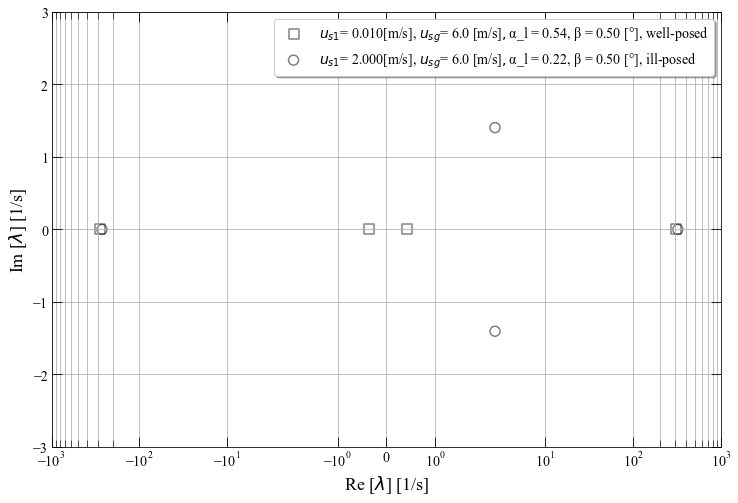

In [8]:
"""
EIGENSPECTRA FOR STRATIFIED SMOOTH AND ILL-POSED REGION

"""
# superficial velocities
mintestj1    = 1e-2
maxtestj1    = 2
testpointsj1 = 2 # 2
j1vectoreig  = np.linspace (mintestj1, maxtestj1, num = testpointsj1) #CREAR UN VECTOR CON PUNTOS DE PRUEBA

mintestj2    = 6
maxtestj2    = 6
testpointsj2 = 1 # 20
j2vectoreig  = np.linspace (mintestj2, maxtestj2, num = testpointsj2) #CREAR UN VECTOR CON PUNTOS DE PRUEBA

#MAP MATRICES----------------------------------------------------------------------------------------------------
u1mapeig     = np.zeros ((testpointsj1,testpointsj2)) #(rows,columns)

k = 0
for beta in betavector:
    print (" >>>  = ", np.rad2deg(beta), "[deg]")
    maprealeig = [[ ] for i in range(testpointsj1)]
    mapimageig = [[ ] for i in range(testpointsj1)]
    
    mapwpeig   = [[ ] for i in range(testpointsj1)]
    
    j = 0 #for each element of j2vector
    for j2 in j2vectoreig: #iterative process for j2
        print (">>j2 = ", j2)
        
        i = 0 #for each element of j1vector
        
        listj1_imageig = [[] for i in range(6)]
        listj1_realeig = [[] for i in range(6)]
        
        for j1 in j1vectoreig: #iterative process for j1
            print (">j1 = ", j1)
            
            #print ("Local equilibrium theory")
            # finding the solution with fsolve
            lima        = 1e-15
            limb        = 1-lima
            u1eig       = brenth (equilibrium1, lima, limb)
            #print("alpha2eq = ", alpha2eq)
            u1mapeig[i] = u1eig
            
            # parameters used in boundary conditions
            u1_0        = u1eig
            u2_0        = u2 (u1eig)
            u3_0        = u3 (u1eig)
            u4_0        = u4eq

            # well-posed analisis
            # phi=[alpha2, u2, u1, p]ˆT
            
            Aevaleig    = np.asarray (Amat (u4_0, u3_0, u2_0, u1_0))
            Aevaleig    = Aevaleig.astype (float)
            #print("Aeval = ", Aeval)

            #print(type(ge(gamma)[0]))
#             print(type(rho1))
            Bevaleig    = np.asarray (Bmat (u4_0, u3_0, u2_0, u1_0, Dc (gamma (u1_0))))
            Bevaleig    = Bevaleig.astype (float)
            #print("Beval = ", Beval)
            
            #criterion for the well-posedness
            #https://scipy.github.io/devdocs/tutorial/arpack.html
            #https://www.netlib.org/lapack/lug/node56.html (if B is singular, infinite eigenvalues) (if a is not singular, the problem can be inverted)
            #m = eigvals (Aeval, Beval)
            
            meig        = eigvals (Bevaleig, b = Aevaleig, overwrite_a = True)
            print("eigenvalues = ", meig)

            length1     = len (meig)
            #print("eigenvaluesvector = ", eigenvaluesvector)
            listrealeig = []
            listimageig = []
            
            l = 0
            for l in range (length1):
                #print("l =", l)
                realpart = meig [l].real                
                imagpart = meig [l].imag
                
                listimageig.append (imagpart)
                listrealeig.append (realpart)
                
            #print("listreal =", listreal)
            #print("listimag =", listimag)
            
            mapimageig[i] = listimageig
            maprealeig[i] = listrealeig

            if all ([ v == 0 for v in listimageig]) :
                condition = 'well-posed'
            else: 
                condition = 'ill-posed'
            
            #print("condition =",  condition)
            mapwpeig[i] = condition
            i += 1      
        j += 1
        
    # Plot eigenspectra
    fig, ax = plt.subplots () #try(3)
    #print("mapreal =", mapreal)
    #print("mapimag =", mapimag)
    
    #https://matplotlib.org/3.1.1/api/markers_api.html
#     listmarkers = ["s", "o", "^", ">", "<", "p"]
    area = 100
            
    for i in range(testpointsj1):
        ax.scatter (maprealeig [i],
                    mapimageig [i], 
                    s = area,
                    marker = listmarkers[i],
                    color = listcolor [4], 
                    edgecolors = listcolor [0],
                    linewidths = 1.5,
                    alpha = 0.5,
                    label = '$u_{s1}$' + '= ' + str("%.3f" %j1vectoreig [i]) + '[m/s]' + ', ' + '$u_{sg}$' + '= ' + str("%.1f" %j2vectoreig) + ' [m/s]' + '$ , $' + 'α_l ' + '= ' + str("%.2f" %u1mapeig [i]) + ', ' + 'β ' + '= ' + str("%.2f" %betavectordeg [k]) + ' [°]' + ', ' + mapwpeig[i])
        ax.set_xscale ('symlog')
#         ax.set_yscale ('symlog')
        
        # minor ticks.
#         ax.xaxis.set_major_locator(MultipleLocator(1))
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        # For the minor ticks, use no labels; default NullFormatter.
#         ax.xaxis.set_minor_locator(MultipleLocator(0.2))
#         ax.yaxis.set_minor_locator(MultipleLocator(0.2))
        ax.xaxis.set_minor_locator(MultipleLocator(100))

        plt.rcParams ['figure.figsize'] = [12, 8]
        leg1 = ax.legend (loc = 'best', frameon = True, fontsize = 14, shadow = True);
        plt.grid (True, which = "both")
        
        matplotlib.rc ('xtick', labelsize = 14)     
        matplotlib.rc ('ytick', labelsize = 14)

        plt.ylim (( - 3  , 3))
        plt.xlim (( - 1e3, 1e3))
        #tick_params(labeltop=False, labelright=True)
        #plt.savefig('well-posedness_map_hilly-terrain_vkh.jpg')
        
        ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

        ax.set_xlabel(r'Re [$\lambda$] [1/s]', fontsize = 18)
        ax.set_ylabel(r'Im [$\lambda$] [1/s]', fontsize = 18)

        plt.savefig('09_comp_TFM_stability/well-posedness_map_4_'+ str(k) +'.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')
    plt.show ()
    
    k += 1
    

In [9]:
# End of well-posedness analysis

In [8]:
"""
Two fluid model
compressible
differential equation system
bi-Global stability analysis
"""

j1vector       = np.linspace (minj1, maxj1, num = testpointsj1)
j2vector       = np.linspace (minj2, maxj2, num = testpointsj2) #*****MODIFIQUE DE 1.000, 10.000 PARA 1,1
j1mapstability = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)

k = 0
for beta in betavector:
    print ("  >>> β = ", np.rad2deg(beta), "[deg]")
    j = 0 #for each element of j2vector
    for j2 in j2vector: #iterative process for j2
#         print (">>j2 = ", j2)
        i = 0 #for each element of j1vector
        for j1 in j1vector: #iterative process for j1
#             print (">j1 = ", j1)
            #print("type j1 =", type(j1))
            #print ("Local equilibrium theory")
            # finding the solution with fsolve
            
            #https://docs.scipy.org/doc/scipy/reference/optimize.html
            lima      = 1e-16
            limb      = 1 - lima
            u1eq      = brenth (equilibrium1, lima, limb)
            # A variation on the classic Brent routine to find a zero of the function f between the arguments 
            # a and b that uses hyperbolic extrapolation instead of inverse quadratic extrapolation. There 
            # was a paper back in the 1980’s ... f(a) and f(b) can not have the same signs. Generally on a par 
            #with the brent routine, but not as heavily tested. It is a safe version of the secant method that 
            #uses hyperbolic extrapolation. The version here is by Chuck Harris.
            
            #x0         = 0.001  #initial guess
            #alpha2eq   = fsolve (equilibrium, x0) #Python function
            #print("alpha2eq = ", alpha2eq)
            # parameters used in boundary conditions
            u1_0       = u1eq
            u2_0       = u2 (u1eq)
            u3_0       = u3 (u1eq)
            u4_0       = u4eq

            # Bi-Global stability analysis
            # phi=[alpha2, u2, u1, p]ˆT
            
            Aeval      = np.asarray (Amat (u4_0, u3_0, u2_0, u1_0))
            Aeval      = Aeval.astype (float)
#             print("Aeval= ", Aeval)

            Beval      = np.asarray (Bmat (u4_0, u3_0, u2_0, u1_0, Dc (gamma (u1_0))))
            Beval      = Beval.astype (float)
#             print("Beval = ", Beval)
            
            Deval      = np.asarray (Dmat (u4_0, u3_0, u2_0, u1_0, S1 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)),      f1 (Re1 (u3 (u1_0), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))),   f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma(u1_0)), Si (gamma(u1_0)))),  fi (f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0))))  )    ))
            Deval      = Deval.astype (float)
#             print("Deval=",Deval)

            Acomplex   = Deval.dot (1j)
            Bcomplex   = Beval.dot (1j)
            Dcomplex   = Deval.dot (1j)
            
            #criterion for well-posedness
            #https://scipy.github.io/devdocs/tutorial/arpack.html
            wavenumber = 2*pi
            m          = eigvals ( ( - wavenumber*Beval + Dcomplex), b = - Aeval, overwrite_a = True) 
#             print("eigenvalues = ", m)
            length1    = len (m)
            
            #print("eigenvaluesvector = ", eigenvaluesvector)
            listreal   = []
            listimag   = []
            
            l = 0
            for l in range (length1):
                #print("l =", l)
                realpart = m [l].real                
                imagpart = m [l].imag
                
                listimag.append (imagpart)
                listreal.append (realpart)
            
            #print("listreal =", listreal)
            #print("listimag =", listimag)
            
            if listimag [0] > 0:
                condition = 'unstable1'
#                 print("condition =",  condition)
                j1mapstability [k, j] = j1
                break
            elif listimag [1] > 0:
                condition = 'unstable2'
#                 print("condition =",  condition)
                j1mapstability [k, j] = j1
                break
            elif listimag [2] > 0:
                condition = 'unstable3'
#                 print("condition =",  condition)
#                 print("this is j1 =", j1)
                j1mapstability [k, i] = j1
                break
            elif listimag [3] > 0:
                condition = 'unstable4'
#                 print("condition =",  condition)
#                 print("this is j1 =", j1)
                j1mapstability [k, j] = j1
                break
            else:
                condition = 'stable'
#                 print("condition =",  condition)  
                i += 1 
        j += 1
    k += 1

  >>> β =  -5.0 [deg]
  >>> β =  0.0 [deg]
  >>> β =  0.25 [deg]


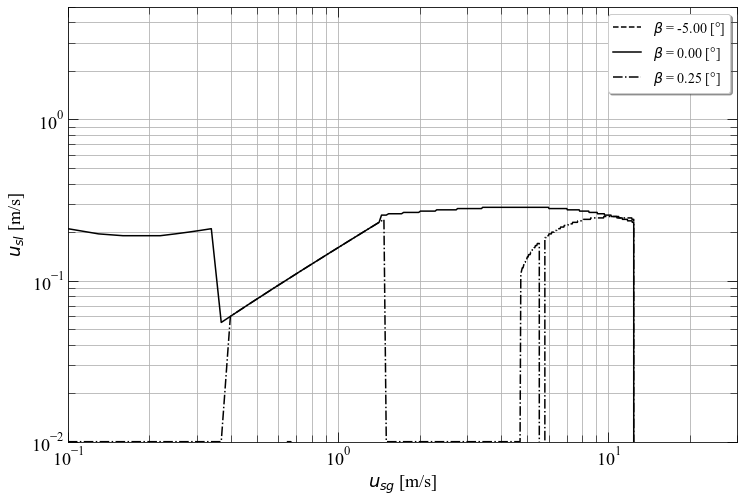

<Figure size 864x576 with 0 Axes>

In [9]:
"""
Bi-Global STABILITY ANALYSIS FOR A CONSTANT WAVELENGTH: PLOT
"""
x = j2vector
fig, ax = plt.subplots ()

for i in range(testpointsbeta):
    ax.loglog (x,
               j1mapstability [i, :],
               liststyles [i],
               color = 'k' ,
               label = '$β$' + ' = ' + str("%.2f" %betavectordeg [i]) + ' [°]')
    #ax.set_xscale ('symlog')
    #ax.set_yscale ('symlog')
    #ax.scatter (mapreal [number], mapimag [number], s = area, marker = listmarkers[number], color='k', alpha = 0.5, label = '$j_1$' + '=' +str("%.2f" %j1vector [number]) + ' m/s')

# Savitzky-Golay Filter
# for i in range (testpointsbeta): #scipy.signal.savgol_filter: window size 51, polynomial order 3  *******63, 1
#     ax.loglog (x, scipy.signal.savgol_filter(j1mapstability [i,:], 93, 1), liststyles [i], color = 'k', label = '$beta$' + ' = '+str("%.2f" %betavectordeg [i]) + ' deg')

#plt.title('Well-posedness limit for horizontal and inclined pipes')

plt.ylim ((minj1, maxj1))
plt.xlim ((minj2, maxj2))

#tick_params(labeltop=False, labelright=True)
plt.grid (True, which = "both")
plt.rcParams ['figure.figsize'] = [12, 8]
leg = ax.legend (loc = 'best', fontsize = 14, shadow = True);

matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

ax.set_xlabel(r'$u_{sg}$ [m/s]',
            fontsize = 18)
ax.set_ylabel(r'$u_{sl}$ [m/s]',
            fontsize = 18)

plt.show ()
plt.savefig('09_comp_TFM_stability/stability_map_1.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

In [12]:
"""
Bi-Global STABILITY ANALYSIS FOR A CONSTANT WAVELENGTH: MAP OF ROLL-WAVES
"""
x = j2vector

i = 0
for i in range(testpointsbeta):
    fig, ax    = plt.subplots ()
    criteria   = ["neutral stability", "limit of well-posedness"]
    
    # neutral stability
    ax.loglog (x,
               j1mapwellposedness [i, :],
               liststyles [2],
               color = listcolor [0],
               label = criteria [1] + ' , ' + '$β$' + ' = ' + str("%.2f" %betavectordeg [i]) + ' [°]')
#     ax.loglog (x, j1mapstability [i, :], liststyles [i], color = 'k', label = criteria [0] + ' , ' + '$beta$' + ' = ' + str("%.2f" %betavectordeg [i]) + ' deg')
    
    # Savitzky-Golay Filter ****83, 1
    ax.loglog (x,
               scipy.signal.savgol_filter(j1mapstability [i,:], 93, 1), #93, 1
               liststyles [0], color = listcolor [0],
               label = criteria [0] + ' , ' + '$β$' + ' = ' + str("%.2f" %betavectordeg [i]) + ' [°]')
    
    # line of constant alpha
    ax.loglog (x,
               j1linemap [i, :],
               liststyles [1],
               color = listcolor [0],
               label =  'α_l = 0.5 [-]')
    
  # Fill
    ax.fill_between(x,
                    scipy.signal.savgol_filter(j1mapstability [i,:], 9, 1),
                    j1mapwellposedness [i, :],
                    where = j1mapwellposedness [i, :] >= scipy.signal.savgol_filter(j1mapstability [i,:], 93, 1),
                    facecolor = 'silver',
                    interpolate = True)    #ax.scatter (mapreal [number], mapimag [number], s = area, marker = listmarkers[number], color='k', alpha = 0.5, label = '$j_1$' + '=' +str("%.2f" %j1vector [number]) + ' m/s') 
    
    #Scatter
    ax.plot(j2test2 [i, :], j1test2 [i, :], 's', color = 'black')
    
    plt.ylim ((minj1, maxj1))
    plt.xlim ((minj2, maxj2))

    #plt.title('Well-posedness limit for horizontal and inclined pipes')
    #tick_params(labeltop=False, labelright=True)
    plt.grid (True, which = "both")
    plt.rcParams ['figure.figsize'] = [12, 8]
    leg = ax.legend (loc = 'best', frameon = True, fontsize = 14, shadow = True);

    matplotlib.rc ('xtick', labelsize = 18)     
    matplotlib.rc ('ytick', labelsize = 18)

    ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

    
    ax.set_xlabel(r'$u_{sg}$ [m/s]',
            fontsize = 18)
    ax.set_ylabel(r'$u_{sl}$ [m/s]',
            fontsize = 18)

    plt.show ()
    plt.savefig('09_comp_TFM_stability/stability_map_2_'+ str(i) +'.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

    i += 1

ValueError: 
limit of well-posedness , r$eta$ = -5.00 [°]
                           ^
Expected end of text, found '$'  (at char 27), (line:1, col:28)

<Figure size 864x576 with 1 Axes>

<Figure size 864x576 with 0 Axes>

ValueError: 
limit of well-posedness , r$eta$ = 0.00 [°]
                           ^
Expected end of text, found '$'  (at char 27), (line:1, col:28)

<Figure size 864x576 with 1 Axes>

<Figure size 864x576 with 0 Axes>

ValueError: 
limit of well-posedness , r$eta$ = 0.25 [°]
                           ^
Expected end of text, found '$'  (at char 27), (line:1, col:28)

<Figure size 864x576 with 1 Axes>

<Figure size 864x576 with 0 Axes>

In [11]:
# End of Bi-Global stability analysis. Mudar sinakl de perturbacao. Plot 3d de como se reduz a area de roll-waves.  Computar as propriedades dos pontos scatter y colocar numa tabela.

  >>>> β =  -1.5000000000000002 [deg]


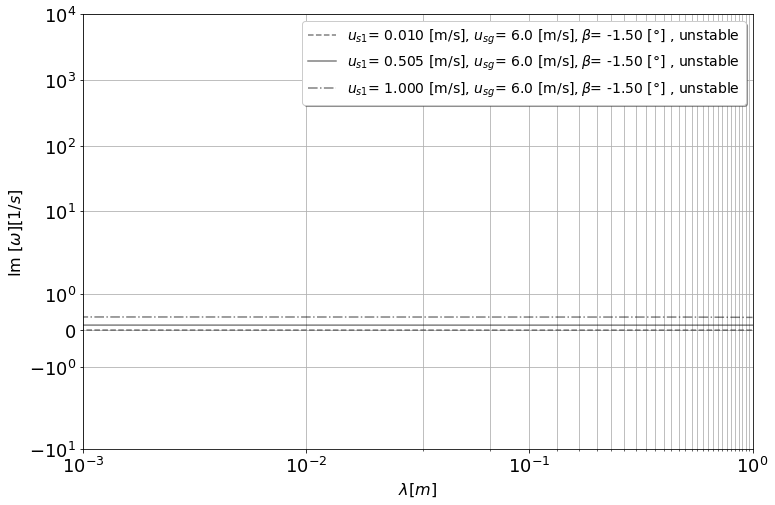

  >>>> β =  0.0 [deg]


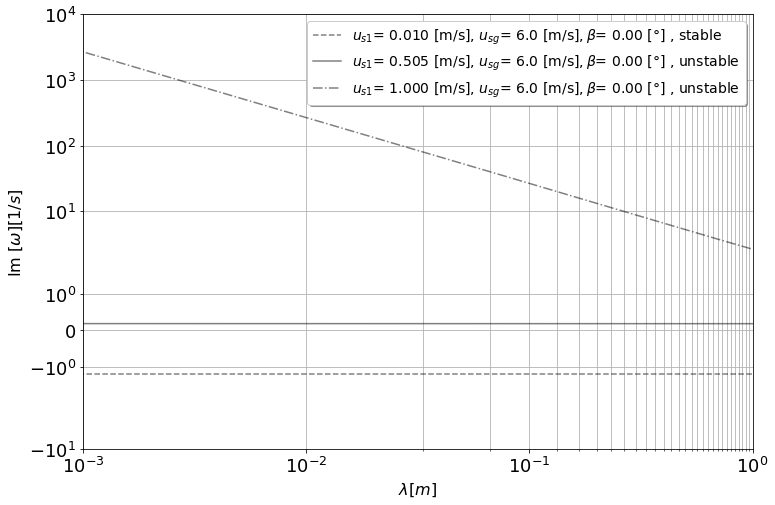

  >>>> β =  0.5 [deg]


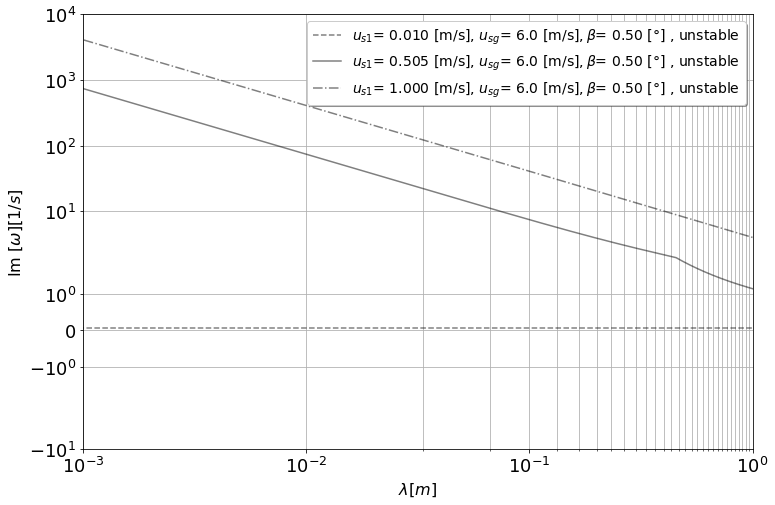

In [15]:
"""
Two fluid model
compressible
differential equation system
Fourier analysis
"""

# superficial velocities
minj1          = 0.01
maxj1          = 1.0
testpointsj1   = 3 # 250
j1vector       = np.linspace (minj1, maxj1, num = testpointsj1)

minj2          = 6
maxj2          = 6
testpointsj2   = 1 # 250
j2vector       = np.linspace (minj2, maxj2, num = testpointsj2) #*****MODIFIQUE DE 1.000, 10.000 PARA 1,1

lambdavector   = np.linspace (minlambda, maxlambda, num = testpointslambda)

#MAP MATRICES----------------------------------------------------------------------------------------------------
j1mapstability = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)

#print("first j1map=", j1map)
k = 0
for beta in betavector:
    print ("  >>>> β = ", np.rad2deg(beta), "[deg]")
    
    imagmap = np.zeros ((testpointsj1,testpointslambda)) #(rows,columns)
    mapwp   = [[ ] for i in range(testpointsj1)]
    
    j = 0 #for each element of j2vector
    for j2 in j2vector: #iterative process for j2
        #print (">>>j2 = ", j2)
        
        i = 0 #for each element of j1vector
        for j1 in j1vector: #iterative process for j1
            #print (">>j1 = ", j1)
            #print("type j1 =", type(j1))
            #print ("Local equilibrium theory")
            
            #https://docs.scipy.org/doc/scipy/reference/optimize.html
            lima     = 1e-16
            limb     = 1 - lima
            u1eq     = brenth (equilibrium1, lima, limb)

            #x0         = 0.001  #initial guess
            #alpha2eq   = fsolve (equilibrium, x0) #Python function
            #print("alpha2eq = ", alpha2eq)

            # parameters used in boundary conditions
            u1_0     = u1eq
            u2_0     = u2 (u1eq)
            u3_0     = u3 (u1eq)
            u4_0     = u4eq

            # Bi-Global stability analysis
            # phi=[alpha2, u2, u1, p]ˆT
                    
            Aeval    = np.asarray (Amat (u4_0, u3_0, u2_0, u1_0))
            Aeval    = Aeval.astype (float)
#             print("Aeval= ", Aeval)

            Beval    = np.asarray (Bmat (u4_0, u3_0, u2_0, u1_0, Dc (gamma (u1_0))))
            Beval    = Beval.astype (float)
#             print("Beval = ", Beval)
            
            Deval    = np.asarray (Dmat (u4_0, u3_0, u2_0, u1_0, S1 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)),      f1 (Re1 (u3 (u1_0), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))),   f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma(u1_0)), Si (gamma(u1_0)))),  fi (f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0))))  )    ))
            Deval    = Deval.astype (float)
#             print("Deval=",Deval)

            Acomplex = Deval.dot (1j)
            Bcomplex = Beval.dot (1j)
            Dcomplex = Deval.dot (1j)
            
            #print("Dcomplex =", Dcomplex)
            
            #criterion for well-posedness
            #https://scipy.github.io/devdocs/tutorial/arpack.html
            h = 0
            for wavelength in lambdavector:
                #print("> wavelength = ", wavelength)

                wavenumber = 2*pi/wavelength

                m          = eigvals ( ( - wavenumber*Beval + Dcomplex), b = - Aeval, overwrite_a = True)

                #print("eigenvalues = ", m)
                length1    = len (m)

                #print("eigenvaluesvector = ", eigenvaluesvector)
                listreal   = []
                listimag   = [] 

                l = 0
                for l in range (length1):
                    #print("l =", l)
                    realpart = m [l].real                
                    imagpart = m [l].imag

                    listimag.append (imagpart)
                    listreal.append (realpart)

                max_eigval = max(listimag)
                min_eigval = min(listimag)
                
                #print("listimag =", listimag)
                #j1mapstability [k, j] = j1

                if any ([ v > 0 for v in listimag]) :
                    condition      = 'unstable'
                    imagmap [i, h] = max_eigval
                    mapwp[i]       = condition
                    #print("condition = " , condition)
                    #print("maximo_autovalor =", max_eigval)
                else: 
                    condition      = 'stable'
                    imagmap [i, h] = min_eigval
                    mapwp[i]       = condition
                    #print("condition = " , condition)
                    #print("minimo_autovalor =", min_eigval)
                h +=1
            i += 1 
        j += 1
        
    #print("imagmap = ", imagmap)
    #print("lambdavector = ", lambdavector)
    
    # Plot of eigenspectra
    fig, ax = plt.subplots ()

    #https://matplotlib.org/3.1.1/api/markers_api.html      
    for i in range(testpointsj1):
        ax.plot (lambdavector,
                 imagmap [i],
                 liststyles [i],
                 color = listcolor [0],
                 alpha = 0.5,
                 label = '$u_{s1}$' + '= ' + str("%.3f" %j1vector [i]) + ' [m/s]' + ', ' + '$u_{sg}$' + '= ' + str("%.1f" %j2vector) + ' [m/s]' + '$ , $' + '$β $' + '= ' + str("%.2f" %betavectordeg [k]) + ' [°]' + ' , ' + mapwp[i])
        ax.set_xscale ('symlog',
                       linthreshx = limitlog)
        ax.set_yscale ('symlog')
        
        # minor ticks.
#         ax.xaxis.set_major_locator(MultipleLocator(0.25))
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))      
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        
        # For the minor ticks, use no labels; default NullFormatter.
        ax.xaxis.set_minor_locator(MultipleLocator(steplambda))
                
        plt.rcParams ['figure.figsize'] = [12, 8]
        leg1 = ax.legend (loc = 'best', frameon = True, fontsize = 14, shadow = True);
        plt.grid (True, which = "both")
        plt.ylim (( - 10, 10000))
        plt.xlim ((limitlog, L))
        #plt.title('Well-posedness limit for horizontal and inclined pipes')
#         tick_params(labeltop=False, labelright=True)
        #plt.savefig('well-posedness_map_hilly-terrain_vkh.jpg')
        matplotlib.rc ('xtick', labelsize = 18)     
        matplotlib.rc ('ytick', labelsize = 18)
        
        ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
        
        ax.set_xlabel(r'$\lambda$ [m]',
            fontsize = 18)
        ax.set_ylabel(r'Im[$\omega$] [1/s]',
            fontsize = 18)

        plt.savefig('09_comp_TFM_stability/fourier_1_'+ str(k) +'.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

    plt.show ()
    
    k += 1

  >>>> β =  -1.5000000000000002 [deg]


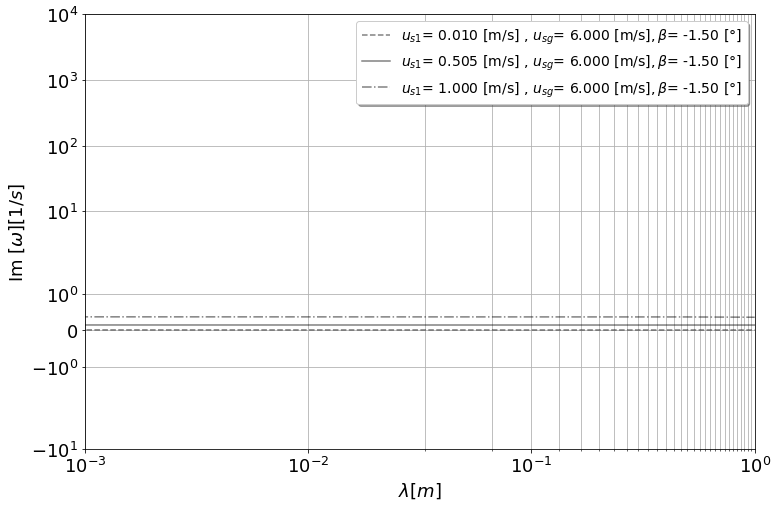

  >>>> β =  0.0 [deg]


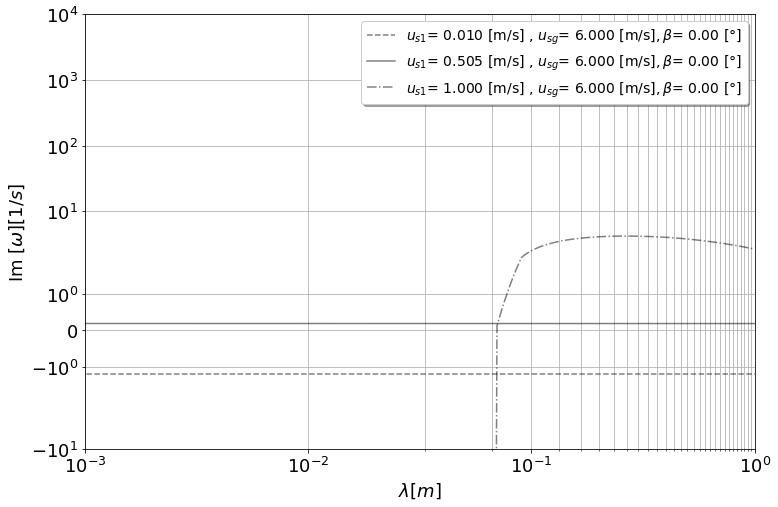

  >>>> β =  0.5 [deg]


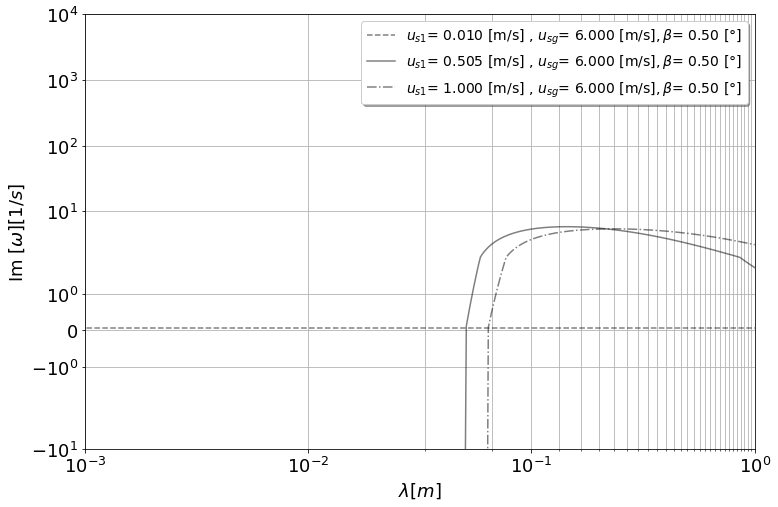

In [17]:
"""
FOURIER ANALYSIS FOR A CONSTANT GAS SUPERFICIAL VELOCITY: HIGHER ORDER REGULARIZATION 
"""
# superficial velocities
minj1          = 0.01
maxj1          = 1.0
testpointsj1   = 3 # 250
j1vector       = np.linspace (minj1, maxj1, num = testpointsj1)

minj2          = 6
maxj2          = 6
testpointsj2   = 1 # 250
j2vector       = np.linspace (minj2, maxj2, num = testpointsj2) #*****MODIFIQUE DE 1.000, 10.000 PARA 1,1

lambdavector   = np.linspace (minlambda, maxlambda, num = testpointslambda)

#MAP MATRICES----------------------------------------------------------------------------------------------------
j1mapstability = np.zeros ((testpointsbeta,testpointsj1)) #(rows,columns)

#print("first j1map=", j1map)

k = 0
for beta in betavector:
    print ("  >>>> β = ", np.rad2deg(beta), "[deg]")

    imagmap = np.zeros ((testpointsj1,testpointslambda)) #(rows,columns)
    mapwp   = [[ ] for i in range(testpointsj1)]
    
    j = 0 #for each element of j2vector
    for j2 in j2vector: #iterative process for j2
        #print (">>>j2 = ", j2)
        
        i = 0 #for each element of j1vector
        for j1 in j1vector: #iterative process for j1
            #print (">>j1 = ", j1)
            #print("type j1 =", type(j1))
            #print ("Local equilibrium theory")
            # finding the solution with fsolve
            
            #https://docs.scipy.org/doc/scipy/reference/optimize.html
            lima      = 1e-16
            limb      = 1 - lima
            u1eq      = brenth (equilibrium1, lima, limb)
            # A variation on the classic Brent routine to find a zero of the function f between the arguments 
            # a and b that uses hyperbolic extrapolation instead of inverse quadratic extrapolation. There 
            # was a paper back in the 1980’s ... f(a) and f(b) can not have the same signs. Generally on a par 
            #with the brent routine, but not as heavily tested. It is a safe version of the secant method that 
            #uses hyperbolic extrapolation. The version here is by Chuck Harris.
            
            #x0         = 0.001  #initial guess
            #alpha2eq   = fsolve (equilibrium, x0) #Python function
            
            #print("alpha2eq = ", alpha2eq)

            # parameters used in boundary conditions
            u1_0       = u1eq
            u2_0       = u2 (u1eq)
            u3_0       = u3 (u1eq)
            u4_0       = u4eq

            # Bi-Global stability analysis
            # phi=[alpha2, u2, u1, p]ˆT
                    
            Aeval    = np.asarray (Amat (u4_0, u3_0, u2_0, u1_0))
            Aeval    = Aeval.astype (float)
#             print("Aeval= ", Aeval)

            Beval    = np.asarray (Bmat (u4_0, u3_0, u2_0, u1_0, Dc (gamma (u1_0))))
            Beval    = Beval.astype (float)
#             print("Beval = ", Beval)
            
            Deval    = np.asarray (Dmat (u4_0, u3_0, u2_0, u1_0, S1 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)),      f1 (Re1 (u3 (u1_0), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))), dh1 (A1 (gamma (u1_0)), S1 (gamma (u1_0)))),   f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma(u1_0)), Si (gamma(u1_0)))),  fi (f2 (Re2 (u2 (u1_0), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0)))), dh2 (A2 (gamma (u1_0)), S2 (gamma (u1_0)), Si (gamma (u1_0))))  )    ))
            Deval    = Deval.astype (float)
#             print("Deval=",Deval)

            Eeval    = np.asarray (Emat (u4_0, u1_0, Gammavector [k,i], Art_mu1vector [k,i], Art_mu2vector [k,i]))
            Eeval    = Eeval.astype (float)
            
            #print("Deval=",Deval)
            Acomplex = Deval.dot (1j)
            Bcomplex = Beval.dot (1j)
            Dcomplex = Deval.dot (1j)
            Ecomplex = Eeval.dot (1j)

            #print("Dcomplex =", Dcomplex)
            
            #criterion for well-posedness
            #https://scipy.github.io/devdocs/tutorial/arpack.html
            h = 0
            for wavelength in lambdavector:
                #print("> wavelength = ", wavelength)
                wavenumber = 2*pi/wavelength

                m = eigvals ( ( - wavenumber*Beval + Dcomplex - pow (wavenumber, 2)*Ecomplex), b = - Aeval, overwrite_a = True) # teste hoje COMB 2

#                 m = eigvals ( ( - wavenumber*Beval - Dcomplex), Aeval) # teste hoje COM1
                #m = eigs (rhs, k = eignumber, M = lhs, return_eigenvectors = False)
                #print("eigenvalues = ", m)
                length1 = len (m)

                #print("eigenvaluesvector = ", eigenvaluesvector)
                listreal = []
                listimag = []

                l = 0
                for l in range (length1):
                    #print("l =", l)
                    realpart = m [l].real                
                    imagpart = m [l].imag

                    listimag.append (imagpart)
                    listreal.append (realpart)

                max_eigval = max (listimag)
                min_eigval = min (listimag)
                
                #print("listimag =", listimag)
                
                #j1mapstability [k, j] = j1

                if any ([ v > 0 for v in listimag]) :
                    condition      = 'unstable'
                    imagmap [i, h] = max_eigval
                    mapwp[i]       = condition
                    #print("condition = " , condition)
                    #print("maximo_autovalor =", max_eigval)
                else: 
                    condition      = 'stable'
                    imagmap [i, h] = min_eigval
                    mapwp[i]       = condition
                    #print("condition = " , condition)
                    #print("minimo_autovalor =", min_eigval)
                
                h +=1
            i += 1 
        j += 1
        
    #print("imagmap = ", imagmap)
    #print("lambdavector = ", lambdavector)
    
    # Plot of eigenspectra
    fig, ax = plt.subplots ()
    
    #print("mapreal =", mapreal)
    #print("mapimag =", mapimag)
    
    #https://matplotlib.org/3.1.1/api/markers_api.html
    
    for i in range(testpointsj1):
        ax.plot (lambdavector,
                 imagmap [i],
                 liststyles [i],
                 color = listcolor [0],
                 alpha = 0.5, label = '$u_{s1}$' + '= ' + str("%.3f" %j1vector [i]) + ' [m/s]' + ' , ' + '$u_{sg}$' + '= ' + str("%.3f" %j2vector) + ' [m/s]' + '$ , $' + '$β $' + '= ' + str("%.2f" %betavectordeg [k]) + ' [°]')
        ax.set_xscale ('symlog',
                       linthreshx = limitlog)
        ax.set_yscale ('symlog')
        
        # minor ticks
#         ax.xaxis.set_major_locator(MultipleLocator(1))
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        
        # For the minor ticks, use no labels; default NullFormatter.
        ax.xaxis.set_minor_locator(MultipleLocator(steplambda))

        plt.rcParams ['figure.figsize'] = [12, 8]
        leg1 = ax.legend (loc = 'best', frameon = True, fontsize = 14, shadow = True);
        plt.grid (True, which = "both")
        ax.set_xlabel ('$\lambda [m]$', fontsize = 18)
        ax.set_ylabel ('Im $[\omega] [1/s]$', fontsize = 18)
        plt.ylim (( - 10, 10000))
        plt.xlim ((limitlog, L))
        
        ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')

        ax.set_xlabel(r'$\lambda$ [m]',
            fontsize = 18)
        ax.set_ylabel(r'Im[$\omega$] [1/s]',
            fontsize = 18)
        
        plt.savefig('09_comp_TFM_stability/fourier_2_'+ str(k) +'.png',
            ppi = 1200,
            transparent = True,
            bbox_inches = 'tight')

    plt.show ()
    
    k += 1

In [ ]:
# end Fourier analysis

In [ ]:
# Matplotlib guide
# https://matplotlib.org/gallery.html

# Characteristics matplotlib
# https://matplotlib.org/3.1.0/tutorials/text/text_intro.html

# Add LaTeX
# https://stackoverflow.com/questions/58121461/runtimeerror-failed-to-process-string-with-tex-because-latex-could-not-be-found

# Matplotlib for punblications
# https://towardsdatascience.com/an-introduction-to-making-scientific-publication-plots-with-python-ea19dfa7f51e

# Annotations
# https://matplotlib.org/3.1.0/tutorials/text/annotations.html

In [ ]:
    # text
    plt.text(1.2, 3.0, "ill-posed", fontsize = 14)
    plt.text(1.1, 0.9, "well-posed unstable", fontsize = 14)
    plt.text(1.1, 0.9, "well-posed stable", fontsize = 14)
